# Q-learning

Q-learning is a popular model-free reinforcement learning method. To understand it, we need to first define **return**, **state-value** and **state-action value**.

## Return

Rememember that interacting with Markov decision process results in trace of **states**, **actions** and **rewards**.

$$
<s_0, a_0, r_1, s_1, a_1, r_2, s_2, ..., r_n, s_n>
$$

From this we can define the **total episode reward**:
$$
R = r_1 + r_2 + ... + r_n
$$

and **total future reward** from timestep $t$ forward:
$$
R_t = r_{t+1} + r_{t+2} + ... + r_n
$$

Usually people consider immediate rewards more valuable than future rewards. There is empirical evidence for it in human psychology and economics. Therefore usually we do not use total future reward as is, but **total discounted future reward** from timestep $t$:

$$
R_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + ... + \gamma^{n-t}r_n
$$

$\gamma$ here is **discount rate** with value in range $[0, 1]$. Value $0$ means we are very short-sighted and consider only immediate rewards. Value $1$ means we are endlessly long-sighted and consider all potential future consequences.

Total discounted future reward is often called **return**. One important property is that return for timestep $t$ can be expressed in terms of reward and return for timestep $t+1$:

$$
R_t = r_{t+1} + \gamma R_{t+1}
$$

**Task 1:** Verify that this holds!

## State-value and state-action value

**State-value** represents the expected (average) return from given state:

$$
V^{\pi}(s) = E \left[ R_t | s_t=a \right]
$$

The expectation in the formula is over environment transitions $P(s_{t+1}|s_t, a_t)$ and future actions chosen by the policy $\pi(a_t|s_t)$. **NB!** Notice that state-value depends on policy $\pi$. Indeed, if you start from the same state, different policies could give you completely different state value.

**State-action value** similarly represents the expected return from given state, after choosing specific action:

$$
Q^{\pi}(s,a) = E \left[ R_t | s_t=s, a_t=a \right]
$$

The state-action value differs from state-value in that we have already fixed the next action. The same way it depends on policy $\pi$ and the expectation in the formula is over environment transitions $P(s_{t+1}|s_t, a_t)$ and future actions chosen by the policy $\pi(a_t|s_t)$.

<!--
State-values and state-action values are tightly connected. State-value can be expressed in terms of state-action value:
$$
V^{\pi}(s) = E_{\pi(a|s)} \left[ Q^{\pi}(s, a) \right]
$$

Similarly state-action value can be expressed in terms of state-value:
$$
Q^{\pi}(s,a) = E_{P(s'|s,a)} \left[ R(s, a, s') + V^{\pi}(s') \right]
$$

In other words state-value is average of state-action values over actions that can be taken by policy $\pi$ in this state. Similarly state-action value is average of state-values over next states where the environment can end up after carrying out given action.
-->

State-action value is often also called **Q-value**, possibly because it represents the quality of the action.

## Bellman optimality equation

<!--
Bellman equation for state-value function looks like this:

$$
V^{\pi}(s) = E \left[ r_t + \gamma V^{\pi}(s_{t+1}) | s = s_t \right]
$$

Bellman equation for state-action value function looks like this:

$$
Q^{\pi}(s, a) = E \left[ r_t + \gamma Q^{\pi}(s_{t+1}, a_{t+1}) | s = s_t, a = a_t \right]
$$
-->

We can define optimal state-values and state-action values as maximum over policies:

$$
V^*(s) = \max_{\pi} V^{\pi}(s)
$$
$$
Q^*(s, a) = \max_{\pi} Q^{\pi}(s, a)
$$

Bellman optimality equation is an important result in reinforcement learning and forms the basis of Q-learning:

$$
Q^*(s,a) = E \left[ r_{t+1} + \gamma \max_{a'} Q^*(s_{t+1}, a') | s_t=s, a_t=a \right]
$$

Consider for a moment that environment is deterministic. In this case we can forget about the expectation and everything becomes very logical - the Q-value for the state and action consists of reward resulting from that action plus Q-value of action that produces *the best return from the next state*.

Finally notice that the optimal state-action value function $Q^*(s,a)$ automatically defines the optimal policy:

$$
\pi^*(s) = argmax_a Q^*(s, a)
$$

Basically if in each state we choose the action with the maximum Q-value, then this is the best thing we can do.

## Tabular Q-learning

In tabular Q-learning we are representing the Q-function as a table with states as rows and actions as columns.

| -     | action1| action2| action3| action4|
|-------|--------|--------|--------|--------|
|state1 |    22.0|    24.4|    22.0|    19.4|
|state2 |    19.8|    22.0|    19.8|    17.8|
|state3 |    17.8|    19.8|    17.8|    16.0|
|state4 |    16.0|    17.8|    16.0|    14.4|

We are updating the Q-table iteratively using Bellman equality equation. In particular for experience $(s, a, r, s')$ we are updating the Q-table as follows:

$$
Q(s, a) = Q(s, a) + \alpha (r + \gamma \max_{a'} Q(s', a') - Q(s, a))
$$

Here $s'$ is the next state, $\alpha$ is the learning rate and $\gamma$ is the discount rate. An alternative way to write the same thing is:

$$
Q(s, a) = (1 - \alpha) Q(s, a) + \alpha (r + \gamma \max_{a'} Q(s', a'))
$$

Basically it is a moving average over Q-values estimated using Bellman optimality equation: take fraction $1 - \alpha$ of previous Q-value and fraction $\alpha$ of the new Q-value. If $\alpha = 0$ then we always get the previous Q-value and nothing is learned. If $\alpha = 1$ then we always use the new estimate for Q-value and learning might be unstable. 

This results in tabular Q-learning algorithm:
```
initialize Q[S,A] arbitrarily
observe initial state s
repeat
    select and carry out an action a
    observe reward r and state s'
    Q[s,a] = Q[s,a] + α(r + γ max_a' Q[s',a'] - Q[s,a])
    s = s'
until termination
```

## Exploration

Tabular Q-learning is proven to converge *if every state is regularly visited*. How do we ensure that? One simple way is $\epsilon$-greedy exploration - with probability $\epsilon$ choose random action and otherwise the greedy action according to maximum Q-value. In other words, with probability $\epsilon$ we are doing **exploration** and with probability $1-\epsilon$ we are doing **exploitation** - making use of the currently known best action.

Alternative exploration strategies are possible. For example in Boltzmann exploration we use softmax operation to convert Q-values into probability distribution and then choose action according to that probability distribution. In practice $\epsilon$-greedy exploration is often better, or at least just as good.

# Example: Frozen Lake

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create Frozen Lake environment
env = gym.make('FrozenLake-v0', is_slippery=False)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Discrete(16)
Action space: Discrete(4)


In [3]:
# extract the number of states and actions from the environment
NUM_STATES = env.observation_space.n
NUM_ACTIONS = env.action_space.n

In [4]:
# initialize Q-table
Q = np.zeros((NUM_STATES, NUM_ACTIONS))
print("Q-table shape:", Q.shape)

Q-table shape: (16, 4)


In [5]:
# hyperparameters of the algorithm
EPSILON = 0.1 # exploration rate
ALPHA = 0.1   # learning rate
GAMMA = 0.9   # discount rate

In [6]:
# reset environment and statistics
episode_reward = 0
episode_length = 0
episode_rewards = []
episode_lengths = []
state = env.reset()

# use 10000 iterations (timesteps)
for i in range(10000):
    # epsilon-greedy exploration
    if np.random.random() < EPSILON:
        # choose random action
        action = np.random.choice(NUM_ACTIONS)
    else:
        # choose greedy action with maximum Q-value
        #action = np.argmax(Q[state])
        # use argmax with random tie-breaking
        idx = np.flatnonzero(Q[state] == np.max(Q[state]))
        action = np.random.choice(idx)

    # step the environment
    new_state, reward, done, info = env.step(action)
    
    # accumulate statistics
    episode_reward += reward
    episode_length += 1
    
    if done:
        # Q-table update at the end of episode - no bootstrapping
        Q[state, action] += ALPHA * (reward - Q[state, action])
        state = env.reset()

        # record statistics
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        episode_reward = 0
        episode_length = 0
    else:
        # Q-table update at the middle of episode - bootstrap from new state Q-value
        Q[state, action] += ALPHA * (reward + GAMMA * np.max(Q[new_state]) - Q[state, action])
        state = new_state

Text(0.5,1,'Episode lengths')

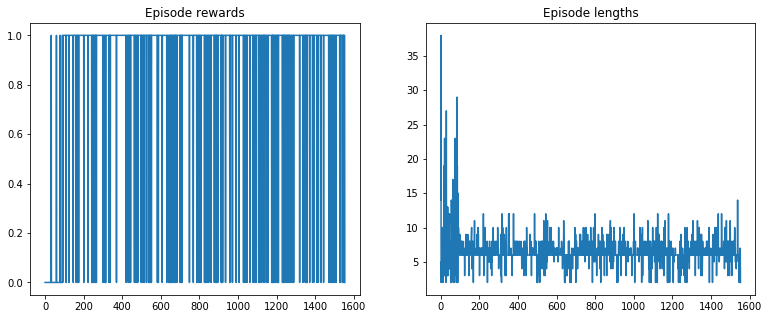

In [7]:
# plot results
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title("Episode rewards")
plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.title("Episode lengths")

Text(0.5,1,'Episode lengths')

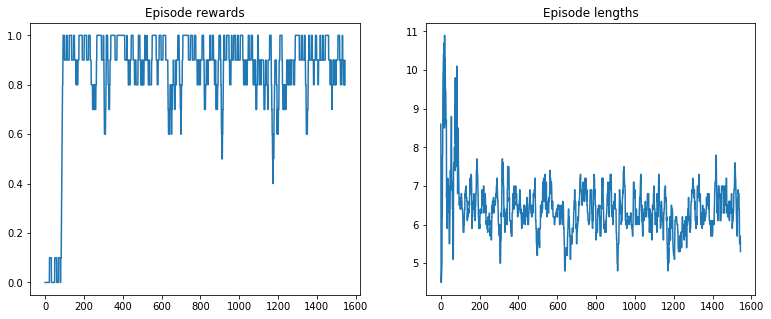

In [8]:
# smooth results with running mean
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(running_mean(episode_rewards, 10))
plt.title("Episode rewards")
plt.subplot(1, 2, 2)
plt.plot(running_mean(episode_lengths, 10))
plt.title("Episode lengths")

## Visualize Q-values

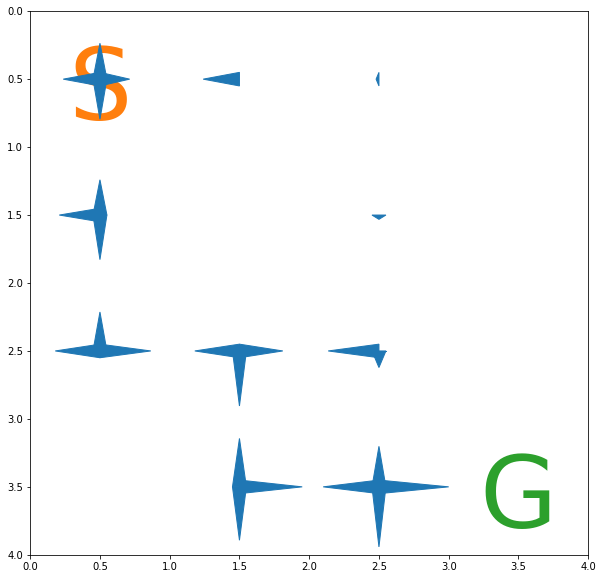

In [9]:
# plot state-value function Q
def plot_arrow(x, y, dx, dy):
    length = float(np.sqrt(dx**2 + dy**2))
    if length > 0:
        plt.arrow(x, y, dx, dy, width=0.1, head_length=length, head_width=0.1, length_includes_head=True, edgecolor='C0')

def plot_qtable(Q, agent_state=None):
    # find size of the grid
    size = int(np.sqrt(Q.shape[0]))
    plt.xlim(0, size)
    plt.ylim(size, 0)

    plt.text(0.5, 0.6, "S", horizontalalignment='center', verticalalignment='center', fontsize=100, color="C1", zorder=0)
    plt.text(3.5, 3.6, "G", horizontalalignment='center', verticalalignment='center', fontsize=100, color="C2", zorder=0)
    
    for y in range(size):
        for x in range(size):
            state = y * size + x
            # LEFT
            plot_arrow(x + 0.5, y + 0.5, -Q[state, 0] / 2, 0)
            # DOWN
            plot_arrow(x + 0.5, y + 0.5, 0, Q[state, 1] / 2)
            # RIGHT
            plot_arrow(x + 0.5, y + 0.5, Q[state, 2] / 2, 0)
            # UP
            plot_arrow(x + 0.5, y + 0.5, 0, -Q[state, 3] / 2)

    if agent_state is not None:
        x = agent_state % size
        y = agent_state // size
        circle = plt.Circle((x + 0.5, y + 0.5), .1, color='C3')
        plt.gca().add_artist(circle)

plt.figure(figsize=(10, 10))
plot_qtable(Q)
plt.show()

On this figure arrows represent the Q-values for four actions in each state: up, down, left, right. The tallest arrow represents the most optimal action.

**Task 2:** Why stepping outside of the borders is also considered action with positive Q-value?

**Task 3:** There are two possible paths to the goal, why sometimes one is discovered, sometimes the other?

In [10]:
# print value function V for greedy policy
V = np.max(Q, axis=1)
print(V.reshape(4, 4))

[[0.59049    0.51990486 0.04091237 0.        ]
 [0.6561     0.         0.0631769  0.        ]
 [0.729      0.81       0.72796608 0.        ]
 [0.         0.9        1.         0.        ]]


In [11]:
# play one episode
done = False
state = env.reset()
env.render()
while not done:
    # use greedy action with maximum Q-value
    action = np.argmax(Q[state])
    state, reward, done, info = env.step(action)
    env.render()


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


## Visualize training

<IPython.core.display.Javascript object>


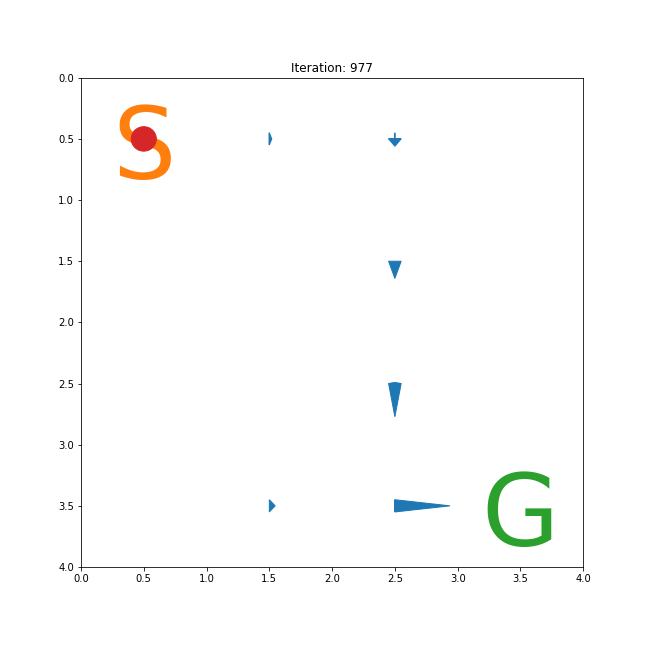

In [ ]:
# make Matplotlib interactive
%matplotlib notebook

# reset Q-table
Q = np.zeros((NUM_STATES, NUM_ACTIONS))

# tabular Q-learning loop
state = env.reset()

# set up figure for updating
plt.figure(figsize=(9, 9))

# use 1000 iterations (timesteps)
for i in range(1000):
    # epsilon-greedy exploration
    if np.random.random() < EPSILON:
        # choose random action
        action = np.random.choice(NUM_ACTIONS)
    else:
        # choose greedy action with maximum Q-value
        #action = np.argmax(Q[state])
        # use argmax with random tie-breaking
        idx = np.flatnonzero(Q[state] == np.max(Q[state]))
        action = np.random.choice(idx)

    # step the environment
    new_state, reward, done, info = env.step(action)
    
    if done:
        # Q-table update at the end of episode - no bootstrapping
        Q[state, action] += ALPHA * (reward - Q[state, action])
        state = env.reset()
    else:
        # Q-table update at the middle of episode - bootstrap from new state Q-value
        Q[state, action] += ALPHA * (reward + GAMMA * np.max(Q[new_state]) - Q[state, action])
        state = new_state

    # clear the figure and plot Q-table
    plt.clf()
    plot_qtable(Q, state)
    plt.title("Iteration: %d" % (i + 1))
    plt.gcf().canvas.draw()

# Final words

We could have solved this particular problem much faster by doing planning, i.e. simulating steps and seeing which steps take us to the goal. But Q-learning is a model-free learning algorithm meaning that it assumes we do not have the model of the environment and cannot simulate it. For example imagine self-driving cars - no simulation would be complete and consider all the possible scenarios. If for your particular task the environment dynamics have well-known form and can be easily simulated, then by any mean, make use of it.